# 변동성 타기팅

|레벨|스타일|기대CAGR|매수전략|매도전략|
|:--:|:--:|:--:|:--:|:--:|
|중급|자산배분|변동성에 따라 다름|- 특정 주가지수, 주식 또는 포트폴리오를 선택<br>- 주가지수, 주식 또는 포트폴리오의 변동성을 계산<br>- 투자 비중을 목표 변동성에 맞춤<br>- 평균 모멘텀 스코어를 통해 다시 한 번 투자 비중을 조정<br>- 나머지 금액은 현금 보유|월 1회 리밸런싱|

# Load Dataset

In [ ]:
import pandas as pd
import requests
from tqdm import tqdm

## KODEX 200

In [ ]:
kodex_200 = pd.DataFrame()
kodex_code = '069500'
url = 'http://finance.naver.com/item/sise_day.nhn?code=' + kodex_code

for page in tqdm(range(1, 100)):
    pg_url = '{url}&page={page}'.format(url=url, page=page)
    pg_url_req = requests.get(pg_url, headers={'User-agent': 'Mozilla/5.0'}).text
    kodex_200 = kodex_200.append(pd.read_html(pg_url_req, header=0)[0], ignore_index=True)
    
kodex_200 = kodex_200.dropna()
kodex_200.columns = ['date', 'close', 'over the day', 'start', 'high', 'low', 'volume']
kodex_200['date'] = pd.to_datetime(kodex_200['date'])

print('출처 :', url)
kodex_200.head()

100%|██████████| 99/99 [00:18<00:00,  5.37it/s]

출처 : http://finance.naver.com/item/sise_day.nhn?code=069500


,date,close,over the day,start,high,low,volume
1,2021-07-14,43400.0,150.0,43400.0,43465.0,43225.0,2074903.0
2,2021-07-13,43550.0,365.0,43380.0,43565.0,43380.0,3654600.0
3,2021-07-12,43185.0,385.0,43060.0,43260.0,43060.0,3929269.0
4,2021-07-09,42800.0,460.0,42840.0,43050.0,42445.0,8288519.0
5,2021-07-08,43260.0,455.0,43765.0,43875.0,43260.0,5209381.0


### Calculate Volatility (monthly)

In [ ]:
# pandas std use 'unbiased estimator' with (N-1) sample
kodex_200[(kodex_200['date'].dt.year == 2018) & (kodex_200['date'].dt.month == 12)].close.std()

348.66369795120033

In [ ]:
# numpy std use N-sample

import numpy as np

np.std(kodex_200[(kodex_200['date'].dt.year == 2018) & (kodex_200['date'].dt.month == 12)].close)

339.3643234701039

In [ ]:
kodex_monthly = pd.DataFrame()
for i in tqdm(range(2010, 2020)):
    for j in range(1, 13):
        kodex_monthly = kodex_monthly.append(kodex_200[(kodex_200['date'].dt.year == i) & (kodex_200['date'].dt.month == j)].head(1))
        
kodex_index = [x for x in range(len(kodex_monthly))]
kodex_monthly.index = kodex_index
kodex_monthly = kodex_monthly.sort_values(by='date')
kodex_monthly.head()

100%|██████████| 10/10 [00:00<00:00, 11.89it/s]


,date,close,over the day,start,high,low,volume
0,2017-07-31,31460.0,0.0,31320.0,31510.0,31305.0,11381687.0
1,2017-08-31,30810.0,190.0,31025.0,31060.0,30745.0,7255256.0
2,2017-09-29,31700.0,245.0,31470.0,31700.0,31470.0,9891922.0
3,2017-10-31,33375.0,330.0,33050.0,33460.0,33000.0,18472117.0
4,2017-11-30,32535.0,540.0,32860.0,32975.0,32505.0,7858593.0


In [ ]:
std_list = []

for i in range(2010, 2020):
    for j in range(1, 13):
        abs_std = kodex_200[(kodex_200['date'].dt.year == i) & (kodex_200['date'].dt.month == j)].close.std()
        month_mean = kodex_200[(kodex_200['date'].dt.year == i) & (kodex_200['date'].dt.month == j)].close.mean()
        rel_std = abs_std / month_mean * 100 # relative standard deviation
        
        if rel_std > 0:
            std_list.append(rel_std)
        
len(std_list)

30

In [ ]:
# kodex_monthly['std'] = std
len(kodex_monthly)

30

In [ ]:
kodex_monthly['std(%)'] = std_list

kodex_monthly.head()

,date,close,over the day,start,high,low,volume,std(%)
0,2017-07-31,31460.0,0.0,31320.0,31510.0,31305.0,11381687.0,1.211493
1,2017-08-31,30810.0,190.0,31025.0,31060.0,30745.0,7255256.0,1.152808
2,2017-09-29,31700.0,245.0,31470.0,31700.0,31470.0,9891922.0,1.611583
3,2017-10-31,33375.0,330.0,33050.0,33460.0,33000.0,18472117.0,0.702076
4,2017-11-30,32535.0,540.0,32860.0,32975.0,32505.0,7858593.0,0.999823


### Rate of returns

In [ ]:
ror_list = []
for i in range(len(kodex_monthly)):
    try:
        ror = kodex_monthly.close.diff().iloc[i] / kodex_monthly.iloc[i-1].close * 100
    except:
        ror = 0
    ror_list.append(ror)

kodex_monthly['RoR'] = ror_list
    
kodex_monthly = kodex_monthly.fillna(0)
kodex_monthly.head()

,date,close,over the day,start,high,low,volume,std(%),RoR
0,2017-07-31,31460.0,0.0,31320.0,31510.0,31305.0,11381687.0,1.211493,0.000000
1,2017-08-31,30810.0,190.0,31025.0,31060.0,30745.0,7255256.0,1.152808,-2.066116
2,2017-09-29,31700.0,245.0,31470.0,31700.0,31470.0,9891922.0,1.611583,2.888673
3,2017-10-31,33375.0,330.0,33050.0,33460.0,33000.0,18472117.0,0.702076,5.283912
4,2017-11-30,32535.0,540.0,32860.0,32975.0,32505.0,7858593.0,0.999823,-2.516854


In [ ]:
kodex_monthly['plus'] = kodex_monthly['RoR'] > 0
kodex_monthly.head()

,date,close,over the day,start,high,low,volume,std(%),RoR,plus
0,2017-07-31,31460.0,0.0,31320.0,31510.0,31305.0,11381687.0,1.211493,0.000000,False
1,2017-08-31,30810.0,190.0,31025.0,31060.0,30745.0,7255256.0,1.152808,-2.066116,False
2,2017-09-29,31700.0,245.0,31470.0,31700.0,31470.0,9891922.0,1.611583,2.888673,True
3,2017-10-31,33375.0,330.0,33050.0,33460.0,33000.0,18472117.0,0.702076,5.283912,True
4,2017-11-30,32535.0,540.0,32860.0,32975.0,32505.0,7858593.0,0.999823,-2.516854,False


In [ ]:
kodex_monthly['momentum_score'] = kodex_monthly['plus'].rolling(window=12).sum()
kodex_monthly.head(24)

In [ ]:
kodex_monthly = kodex_monthly.fillna(0.0)
kodex_monthly.head(24)

,date,close,over the day,start,high,low,volume,std(%),RoR,plus,momentum_score
0,2017-07-31,31460.0,0.0,31320.0,31510.0,31305.0,11381687.0,1.211493,0.000000,False,0.0
1,2017-08-31,30810.0,190.0,31025.0,31060.0,30745.0,7255256.0,1.152808,-2.066116,False,0.0
2,2017-09-29,31700.0,245.0,31470.0,31700.0,31470.0,9891922.0,1.611583,2.888673,True,0.0
3,2017-10-31,33375.0,330.0,33050.0,33460.0,33000.0,18472117.0,0.702076,5.283912,True,0.0
4,2017-11-30,32535.0,540.0,32860.0,32975.0,32505.0,7858593.0,0.999823,-2.516854,False,0.0
5,2017-12-28,32780.0,405.0,32390.0,32815.0,32385.0,7560958.0,0.825836,0.753035,True,0.0
6,2018-01-31,33705.0,25.0,33565.0,34200.0,33565.0,18955268.0,1.006870,2.821843,True,0.0
7,2018-02-28,31690.0,365.0,31945.0,32100.0,31650.0,7129364.0,2.111156,-5.978341,False,0.0
8,2018-03-30,31960.0,80.0,32115.0,32195.0,31960.0,8620284.0,1.701908,0.852004,True,0.0
9,2018-04-30,32300.0,210.0,32185.0,32305.0,32140.0,4494562.0,0.854948,1.063830,True,0.0


In [ ]:
kodex_monthly = kodex_monthly[11:]
kodex_index = [x for x in range(len(kodex_monthly))]
kodex_monthly.index = kodex_index
kodex_monthly.head()

,date,close,over the day,start,high,low,volume,std(%),RoR,plus,momentum_score
0,2018-06-29,30045.0,65.0,30015.0,30120.0,29695.0,14304926.0,2.092980,-3.392283,False,6.0
1,2018-07-31,29805.0,40.0,29775.0,29815.0,29680.0,5386124.0,0.641866,-0.798802,False,6.0
2,2018-08-31,29960.0,120.0,29710.0,29975.0,29655.0,4563537.0,1.163914,0.520047,True,7.0
3,2018-09-28,30125.0,190.0,30355.0,30355.0,30110.0,6300176.0,1.095829,0.550734,True,7.0
4,2018-10-31,26390.0,120.0,26345.0,26425.0,26130.0,5778168.0,4.149630,-12.398340,False,6.0


# Backtest

In [ ]:
def backtest(beginning_cash=1000000.0, target_vol=1):
    asset=[]
    
    for i in range(len(kodex_monthly) - 1):
        stock_pct = (target_vol / kodex_monthly.iloc[i]['std(%)']) * (kodex_monthly.iloc[i].momentum_score / 12)  
        if stock_pct > 1:
            stock_pct = 1
            
        cash_pct = 1 - stock_pct
            
        stock_shares = (beginning_cash * stock_pct) / kodex_monthly.iloc[i].close
        stock_end = stock_shares * kodex_monthly.iloc[i+1].close
        
        cash_end = beginning_cash * cash_pct
        
        total_end = stock_end + cash_end
        asset.append(total_end)
        beginning_cash = total_end
    
    asset.insert(0, 1000000.0)
    return asset

In [ ]:
result1 = backtest()
result2 = backtest(target_vol = 2)
result3 = backtest(target_vol = 3)
result4 = backtest(target_vol = 4)

In [ ]:
back_test = {
    'date' : kodex_monthly['date'],
    'backtest1' : result1,
    'backtest2' : result2,
    'backtest3' : result3,
    'backtest4' : result4,
    'kodex_200' : kodex_monthly['close'] / kodex_monthly.iloc[0].close * 1000000.0
}

back_test = pd.DataFrame(back_test, columns = ['date', 'backtest1', 'backtest2', 'backtest3', 'backtest4', 'kodex_200'])
back_test.head()

,date,backtest1,backtest2,backtest3,backtest4,kodex_200
0,2018-06-29,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06
1,2018-07-31,9.980917e+05,9.961834e+05,9.942751e+05,9.923668e+05,9.920120e+05
2,2018-08-31,1.002135e+06,1.001364e+06,9.994458e+05,9.975276e+05,9.971709e+05
3,2018-09-28,1.004901e+06,1.006879e+06,1.004950e+06,1.003021e+06,1.002663e+06
4,2018-10-31,9.385786e+05,8.820426e+05,8.803530e+05,8.786633e+05,8.783491e+05


# Visualization

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

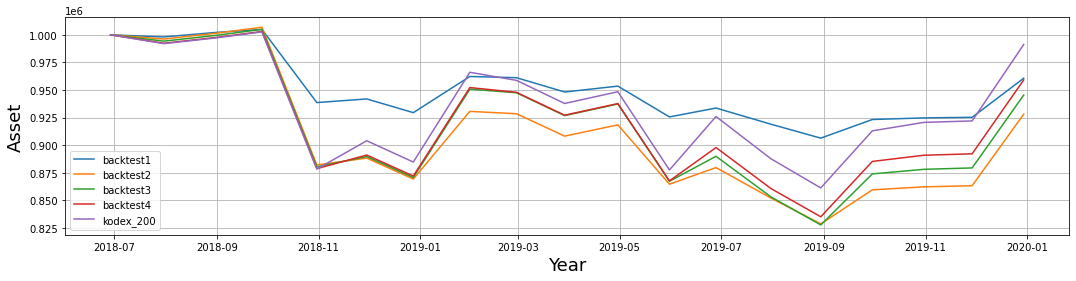

In [ ]:
plt.figure(figsize=(18, 4))
plt.plot(back_test['date'], back_test['backtest1'], label='backtest1')
plt.plot(back_test['date'], back_test['backtest2'], label='backtest2')
plt.plot(back_test['date'], back_test['backtest3'], label='backtest3')
plt.plot(back_test['date'], back_test['backtest4'], label='backtest4')
plt.plot(back_test['date'], back_test['kodex_200'], label='kodex_200')

plt.grid()
plt.legend(loc='best')
plt.xlabel('Year', fontsize=18)
plt.ylabel('Asset', fontsize=18)
plt.show()

# Compute CAGR

### backtest

In [ ]:
begin, end = result1[0], result1[-1]

cagr1 = ((end / begin)**(1/len(set(back_test['date'].dt.year))) - 1) * 100
print('%.2f'%cagr1, '%')

-1.99 %


In [ ]:
begin, end = result2[0], result2[-1]

cagr2 = ((end / begin)**(1/len(set(back_test['date'].dt.year))) - 1) * 100
print('%.2f'%cagr2, '%')

-3.67 %


In [ ]:
begin, end = result3[0], result3[-1]

cagr3 = ((end / begin)**(1/len(set(back_test['date'].dt.year))) - 1) * 100
print('%.2f'%cagr3, '%')

-2.77 %


In [ ]:
begin, end = result4[0], result4[-1]

cagr4 = ((end / begin)**(1/len(set(back_test['date'].dt.year))) - 1) * 100
print('%.2f'%cagr4, '%')

-2.07 %


### KODEX 200

In [ ]:
begin, end = back_test.iloc[0]['kodex_200'], back_test.iloc[-1]['kodex_200']

cagr = ((end / begin)**(1/len(set(back_test['date'].dt.year))) - 1) * 100
print('%.2f'%cagr, '%')

-0.44 %


# Compute Statistics

In [ ]:
# standard deviation of portfolio

import numpy as np
std_pct = (np.std(back_test) / np.mean(back_test)) * 100
std_pct

backtest1    3.171500
backtest2    6.042965
backtest3    5.873525
backtest4    5.568306
kodex_200    4.871015
dtype: float64

In [ ]:
# rates of return

for i in range(len(back_test) - 1):
    back_test['RoR1'] = (back_test['backtest1'].diff() / back_test.iloc[i]['backtest1']) * 100
    back_test['RoR2'] = (back_test['backtest2'].diff() / back_test.iloc[i]['backtest2']) * 100
    back_test['RoR3'] = (back_test['backtest3'].diff() / back_test.iloc[i]['backtest3']) * 100
    back_test['RoR4'] = (back_test['backtest4'].diff() / back_test.iloc[i]['backtest4']) * 100
    back_test['kodex_RoR'] = (back_test['kodex_200'].diff() / back_test.iloc[i]['kodex_200']) * 100
back_test = back_test.fillna(0)
back_test.head(24)

,date,backtest1,backtest2,backtest3,backtest4,kodex_200,RoR1,RoR2,RoR3,RoR4,kodex_RoR
0,2018-06-29,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,0.000000,0.000000,0.000000,0.000000,0.000000
1,2018-07-31,9.980917e+05,9.961834e+05,9.942751e+05,9.923668e+05,9.920120e+05,-0.206249,-0.442138,-0.651040,-0.855612,-0.866426
2,2018-08-31,1.002135e+06,1.001364e+06,9.994458e+05,9.975276e+05,9.971709e+05,0.437005,0.600159,0.588019,0.578479,0.559567
3,2018-09-28,1.004901e+06,1.006879e+06,1.004950e+06,1.003021e+06,1.002663e+06,0.298959,0.638879,0.625956,0.615800,0.595668
4,2018-10-31,9.385786e+05,8.820426e+05,8.803530e+05,8.786633e+05,8.783491e+05,-7.168173,-14.461892,-14.169372,-13.939481,-13.483755
5,2018-11-30,9.418784e+05,8.882446e+05,8.896382e+05,8.910198e+05,9.039774e+05,0.356640,0.718482,1.055924,1.385056,2.779783
6,2018-12-28,9.294579e+05,8.692762e+05,8.706400e+05,8.719922e+05,8.846730e+05,-1.342407,-2.197430,-2.160500,-2.132841,-2.093863
7,2019-01-31,9.622364e+05,9.305884e+05,9.507271e+05,9.522036e+05,9.660509e+05,3.542713,7.102822,9.107623,8.991028,8.826715
8,2019-02-28,9.611444e+05,9.284763e+05,9.474905e+05,9.478814e+05,9.587286e+05,-0.118017,-0.244675,-0.368075,-0.484484,-0.794224
9,2019-03-29,9.481714e+05,9.081694e+05,9.267677e+05,9.271501e+05,9.377600e+05,-1.402131,-2.352490,-2.356623,-2.323804,-2.274368


In [ ]:
# std of RoR

std_ror1 = (np.std(back_test['RoR1']) / np.mean(back_test['RoR1']))
std_ror2 = (np.std(back_test['RoR2']) / np.mean(back_test['RoR2']))
std_ror3 = (np.std(back_test['RoR3']) / np.mean(back_test['RoR3']))
std_ror4 = (np.std(back_test['RoR4']) / np.mean(back_test['RoR4']))
std_kodex_ror = (np.std(back_test['kodex_RoR']) / np.mean(back_test['kodex_RoR']))
print(' std_ror1 :', std_ror1, '\n','std_ror2 :', std_ror2,'\n','std_ror3 :', std_ror3,'\n','std_ror4 :', std_ror4,'\n','kodex_200 :', std_kodex_ror)

 std_ror1 : -10.230892795039845 
 std_ror2 : -10.429198523487184 
 std_ror3 : -15.30830494820005 
 std_ror4 : -20.75729932944515 
 kodex_200 : -99.94215486101267


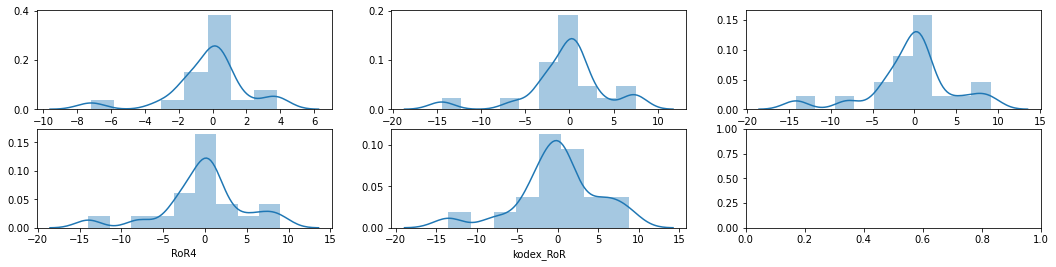

In [ ]:
figure, ((ax1, ax2 ,ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(18,4)


sns.distplot(back_test['RoR1'], ax=ax1)
sns.distplot(back_test['RoR2'], ax=ax2)
sns.distplot(back_test['RoR3'], ax=ax3)
sns.distplot(back_test['RoR4'], ax=ax4)
sns.distplot(back_test['kodex_RoR'], ax=ax5)

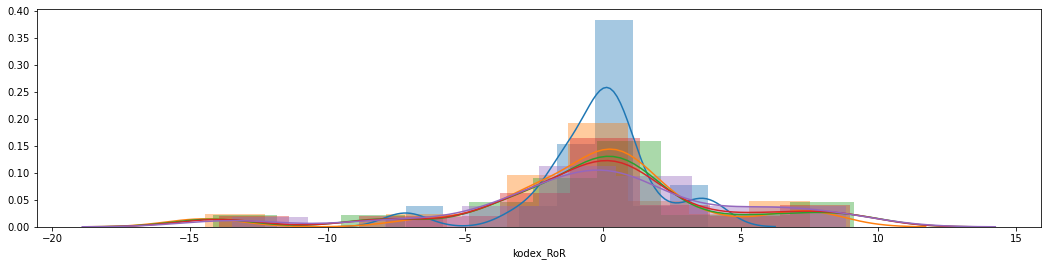

In [ ]:
figure, (ax1) = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(18,4)


sns.distplot(back_test['RoR1'])
sns.distplot(back_test['RoR2'])
sns.distplot(back_test['RoR3'])
sns.distplot(back_test['RoR4'])
sns.distplot(back_test['kodex_RoR'])